Total PnL: -548080.55
Standard Deviation of Hedging Errors: 91348.93


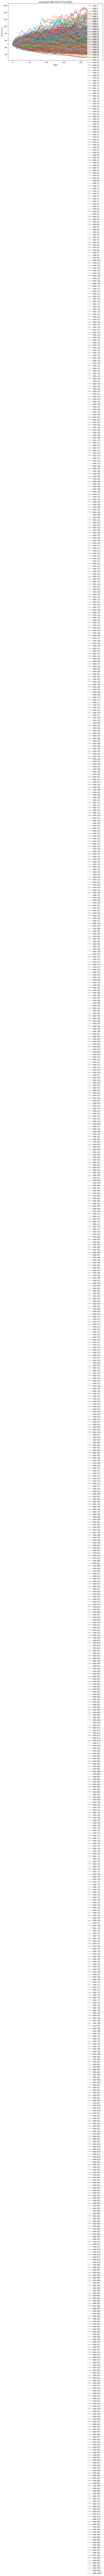

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

class DynamicHedging:
    def __init__(self, S0, K, r, sigma, T, n_contracts, transaction_cost=0.001, n_rebalancing=252):
        
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.n_contracts = n_contracts
        self.transaction_cost = transaction_cost
        self.n_rebalancing = n_rebalancing

    @staticmethod
    def black_scholes(S, K, r, sigma, T):
        
        # Handle array operations correctly
        S = np.asarray(S)  # Ensure S is a NumPy array for vectorized calculations
        
        if np.any(T <= 0):  # When time to maturity is zero or negative
            option_price = np.maximum(S - K, 0)
            delta = np.where(S > K, 1, 0)
            return option_price, delta

        # Calculate d1 and d2 for Black-Scholes
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        # Calculate option price and delta
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
        return option_price, delta


    def simulate_gbm(self, n_days, num_paths=1):
       
        dt = 1 / 252
        Z = np.random.standard_normal((num_paths, n_days))
        daily_returns = np.exp((self.r - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * Z)
        stock_prices = self.S0 * np.hstack([np.ones((num_paths, 1)), daily_returns]).cumprod(axis=1)
        return stock_prices

    def run_hedging(self, n_days, num_paths=1):
       
        stock_prices = self.simulate_gbm(n_days, num_paths)
        dt = 1 / 252
        cash_position = np.zeros(num_paths)
        delta_prev = np.zeros(num_paths)  # Delta from the previous step
        PnL = []  # Track Profit and Loss for each rebalancing step

        for t in range(1, n_days + 1):
            S = stock_prices[:, t]  # Current stock prices for all paths
          
            T = max(self.T - t * dt, 0.00001)
            _, delta = self.black_scholes(S, self.K, self.r, self.sigma, T)

            # Rebalance portfolio
            hedge_change = (delta - delta_prev) * self.n_contracts
            transaction_cost = np.abs(hedge_change) * S * self.transaction_cost
            cash_position -= hedge_change * S + transaction_cost
            delta_prev = delta  # Update delta for the next step

            # Calculate PnL
            portfolio_value = cash_position + delta * S * self.n_contracts
            option_value, _ = self.black_scholes(S, self.K, self.r, self.sigma, T)
            PnL.append(portfolio_value - option_value * self.n_contracts)

        # Final calculations
        final_option_value, _ = self.black_scholes(stock_prices[:, -1], self.K, self.r, self.sigma, 0)
        final_portfolio_value = cash_position + delta_prev * stock_prices[:, -1] * self.n_contracts
        total_PnL = final_portfolio_value - final_option_value * self.n_contracts

        return total_PnL, np.std(PnL), stock_prices

# Example Usage
if __name__ == "__main__":
    # Initialize parameters
    S0 = 50  # Initial stock price
    K = 55  # Strike price
    r = 0.04  # Risk-free rate
    sigma = 0.4  # Volatility
    T = 5.0  # Time to maturity in years
    n_contracts = 100000  # Number of contracts
    n_days = 252  # Number of trading days
    num_paths = 1000  # Number of simulation paths

    # Run simulation
    hedging_sim = DynamicHedging(S0, K, r, sigma, T, n_contracts)
    total_PnL, std_error, stock_prices = hedging_sim.run_hedging(n_days, num_paths)

    # Print results
    print(f"Total PnL: {total_PnL.mean():.2f}")
    print(f"Standard Deviation of Hedging Errors: {std_error:.2f}")

   
  
